In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np


In [6]:
# Define the paths to the data files
DATA_PATH = "../../../data/emotions_interpolated_20.pkl"  # Path to the CSV file containing sentence emotions data
DATA_PATH_MOVIE_METADATA = "../../../data/final_dataset.pkl"  # Path to the pickle file containing movie metadata

df_emotions = pd.read_pickle(DATA_PATH)

with open(DATA_PATH_MOVIE_METADATA, 'rb') as f:
    df_metadata = pickle.load(f)

df_metadata.sample(3)

Wikipedia_movie_ID                                            summary  \
6946              2580131  A meteor streaks across the night sky as Davey...   
13644             6470956  The story opens with Tom Dobbs , a comedian an...   
25098            16431349  A group of students go to a haunted forest cal...   

      Freebase_movie_ID                 Movie_name  Movie_release_date  \
6946          /m/07pdgt  The Giant Spider Invasion                 NaN   
13644         /m/0g6kfj            Man of the Year              2006.0   
25098        /m/03y1ns4      Evil Calls: The Raven              2008.0   

        Movie_box_office_revenue  Movie_runtime   Movie_languages  \
6946   $15 million or $2,347,000           84.0  English Language   
13644                 41237658.0          115.0  English Language   
25098                        NaN           90.0  English Language   

                Movie_countries  \
6946   United States of America   
13644  United States of America   
25098            United Kingdom   

                                            Movie_genres  \
6946   Monster movie, Science Fiction, Horror, Sci-Fi...   
13644  Thriller, Parody, Satire, Drama, Comedy, Polit...   
25098                                             Horror   

                        category      continent  Rating  
6946    [Fantasy/Sci-Fi, Horror]  North America     3.3  
13644  [Comedy, Drama, Thriller]  North America     6.2  
25098                   [Horror]         Europe     2.4

In [7]:
emotion_columns = ['fear', 'sadness', 'surprise', 'neutral']
#keep only the films that are in categories
data = df_emotions.drop('timestep', axis=1).groupby('Wikipedia_movie_ID')[emotion_columns].mean()
data = data.merge(df_metadata[['Wikipedia_movie_ID', 'category']], on='Wikipedia_movie_ID')
data = data.explode('category')
data_with_category = data.dropna()
#a movie can be in more than 1 categories, so we need to keep only 1 sample per movie (hence drop_duplicates())
data = data_with_category.drop(['category'], axis=1).drop_duplicates()
data_with_category = data_with_category['category']

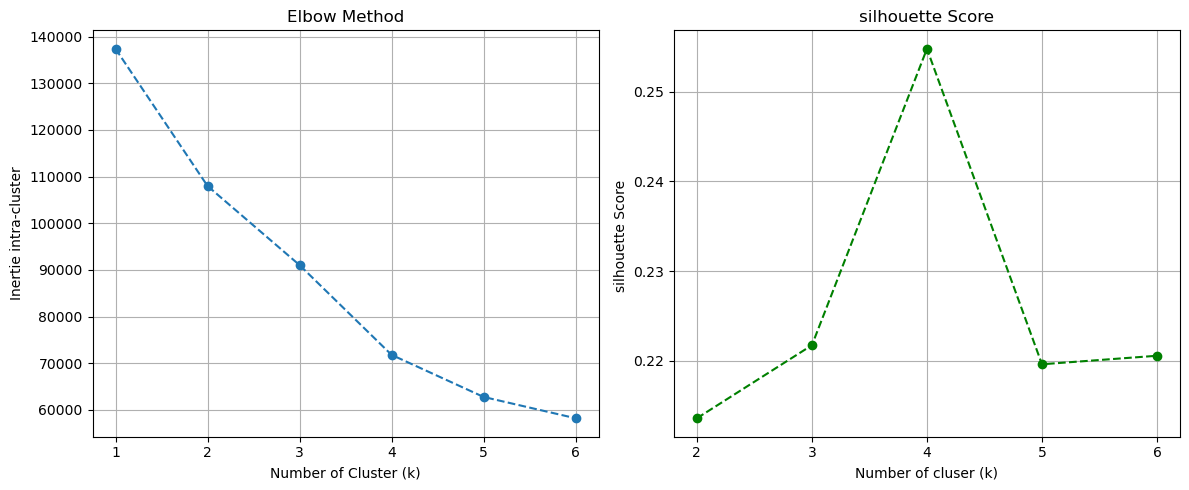

In [8]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop('Wikipedia_movie_ID', axis=1))

inertias = []
silhouette_scores = []
k_values = range(1, 7) 

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    
    inertias.append(kmeans.inertia_)
    #k=1 does not work with the silhouette score
    if k > 1:
        silhouette_avg = silhouette_score(data_scaled, labels)
        silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Cluster (k)')
plt.ylabel('Inertie intra-cluster')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values[1:], silhouette_scores, marker='o', linestyle='--', color='green') 
plt.title('silhouette Score')
plt.xlabel('Number of cluser (k)')
plt.ylabel('silhouette Score ')
plt.xticks(k_values[1:])
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
data_kmeans = data.copy(deep=True)

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=1000)
clusters = kmeans.fit_predict(data_scaled)

data_kmeans['cluster_km'] = clusters

pca = PCA(n_components=3)
data_3d = pca.fit_transform(data_kmeans.drop(['Wikipedia_movie_ID', 'cluster_km'], axis=1))
data_kmeans['PCA1_km'] = data_3d[:, 0]
data_kmeans['PCA2_km'] = data_3d[:, 1]
data_kmeans['PCA3_km'] = data_3d[:, 2]
data_kmeans = data_kmeans.merge(df_metadata[['Wikipedia_movie_ID', 'category']], on='Wikipedia_movie_ID')

In [10]:
plotly_data = pd.DataFrame({
    'PCA1_km': data_kmeans['PCA1_km'],
    'PCA2_km': data_kmeans['PCA2_km'],
    'PCA3_km': data_kmeans['PCA3_km'],
    'Cluster_km': data_kmeans['cluster_km'].astype(str),
    'Wikipedia_movie_ID': data_kmeans['Wikipedia_movie_ID'],
    'category': data_kmeans['category'] 
})

fig = px.scatter_3d(
    plotly_data,
    x='PCA1_km',
    y='PCA2_km',
    z='PCA3_km',
    color='Cluster_km',
    title='Clustering emotions in 3D (KMeans)',
    labels={'Cluster': 'Cluster_km'},
    opacity=0.7,
    width=1000,
    height=800,
    hover_data=["Wikipedia_movie_ID", "category"]
)

fig.show()


In [12]:
# Global Pie Chart with Plotly
labels, counts = np.unique(data_with_category, return_counts=True)
fig_global = go.Figure(
    data=[go.Pie(labels=labels, values=counts, hole=0.3, marker=dict(colors=plt.cm.Paired.colors))],
)
fig_global.update_layout(
    title_text="Overall Category Distribution",
    showlegend=True
)
fig_global.show()

# Cluster-Specific Pie Charts with Plotly
data_kmeans = data_kmeans.explode('category')
#data_kmeans = data_kmeans[data_kmeans['category'].isin(categories)]
category_per_cluster = data_kmeans[['cluster_km', 'category']].groupby('cluster_km').value_counts()
clusters = category_per_cluster.index.get_level_values('cluster_km').unique()
n_clusters = len(clusters)

# Create a subplot layout with 2 pies per row
fig = make_subplots(
    rows=(n_clusters + 1) // 2,  
    cols=2,
    specs=[[{'type': 'domain'}, {'type': 'domain'}] for _ in range((n_clusters + 1) // 2)],  # Domain type for pie charts
    subplot_titles=[f"Cluster {cluster}" for cluster in clusters]  
)

# Add pie charts to subplots
row, col = 1, 1
for cluster in clusters:
    cluster_data = category_per_cluster.loc[cluster]  # Filter the data for the current cluster
    fig.add_trace(
        go.Pie(
            labels=cluster_data.index.get_level_values('category'),
            values=cluster_data.values,
            name=f"Cluster {cluster}"
        ),
        row=row,
        col=col
    )
    col += 1
    if col > 2:  
        row += 1
        col = 1

# Update layout
fig.update_layout(
    title_text="Clusters - Repartition per categorie",
    height=300 * ((n_clusters + 1) // 2),  # Adjust height dynamically based on rows
    showlegend=True
)

# Show the figure
fig.show()


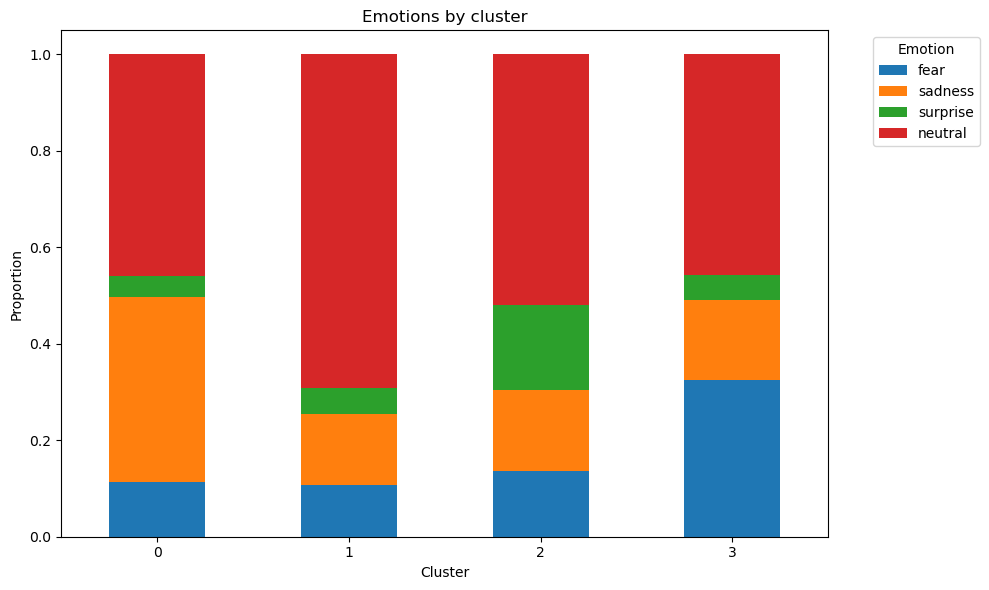

In [13]:
data_km  = data_kmeans.drop(['PCA1_km', 'PCA2_km', 'PCA3_km'], axis=1).copy()
mean_emotions_per_cluster = data_km.drop(['category','Wikipedia_movie_ID'], axis=1).groupby('cluster_km').mean()
mean_emotions_per_cluster = mean_emotions_per_cluster.apply(lambda x: x / x.sum(), axis=1)
mean_emotions_per_cluster.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Emotions by cluster')
plt.ylabel('Proportion')
plt.xlabel('Cluster')
plt.xticks(rotation = 0)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [14]:
cluster_count = data_km.cluster_km.value_counts()
fig_global = go.Figure(
    data=[go.Pie(labels=cluster_count.index, values=cluster_count.values, hole=0.3, marker=dict(colors=plt.cm.Paired.colors))],
)
fig_global.update_layout(
    title_text="cluster size",
    showlegend=True
)
fig_global.show()

In [15]:
data_km_with_continent = data_km.drop('category', axis=1).drop_duplicates().merge(df_metadata[['Wikipedia_movie_ID', 'continent']], on='Wikipedia_movie_ID').drop('Wikipedia_movie_ID', axis=1)
counts_continent_per_cluster = data_km_with_continent[['cluster_km','continent']].groupby('cluster_km')['continent'].value_counts()

In [130]:
de_mean_emotions = df_emotions.drop('timestep', axis=1).groupby('Wikipedia_movie_ID').mean()
corr_7_emotions = de_mean_emotions.corr()
fig = go.Figure(
    data=go.Heatmap(
        z=corr_7_emotions.values,  
        x=corr_7_emotions.columns, 
        y=corr_7_emotions.index,  
        colorscale='Inferno',  
        zmax=0.2,  
        zmin=-0.5,
        text=np.round(corr_7_emotions.values, 3),  
        texttemplate="%{text}", 
        textfont={"size": 10}   
  
    )
)
fig.update_layout(
    title='Correlation between emotions',
    xaxis_title='Emotions',
    yaxis_title='Emotions',
    coloraxis_colorbar=dict(title="Correlation"),  
    width=700,  
    height=700  
)

fig.show()

In [131]:

emotion_per_continent = (
    de_mean_emotions
    .reset_index()
    .merge(df_metadata[['Wikipedia_movie_ID', 'continent']], on='Wikipedia_movie_ID')
    .drop('Wikipedia_movie_ID', axis=1)
)

continents = emotion_per_continent['continent'].unique()

fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=[f"Correlation of emotion in {continent}" for continent in continents],
    specs=[[{'type': 'heatmap'}] * 3 for _ in range(2)]  
)

row, col = 1, 1
for continent in continents:
    df_c = emotion_per_continent[emotion_per_continent['continent'] == continent].drop('continent', axis=1)
    corr_matrix = df_c.corr()
    
    fig.add_trace(
        go.Heatmap(
            z=corr_matrix.values,
            x=corr_matrix.columns,
            y=corr_matrix.index,
            colorscale='inferno',
            zmin=-0.45,  
            zmax=0.4,
            text=np.round(corr_matrix.values, 3),  
            texttemplate="%{text}", 
            textfont={"size": 10}   
        ),
        row=row,
        col=col
    )
    
    
    col += 1
    if col > 3:
        row += 1
        col = 1

fig.update_layout(
    title="Correlation of Emotions by Continent",
    height=1400,
    width=1800, 
    showlegend=False  
)

# Afficher les heatmaps
fig.show()

In [133]:

emotion_per_cluster = data_km.merge(df_emotions[['Wikipedia_movie_ID', 'anger', 'disgust', 'joy']], on='Wikipedia_movie_ID').drop(['Wikipedia_movie_ID', 'category'], axis=1)

clusters = emotion_per_cluster['cluster_km'].unique()

fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=[f"Correlation of emotion in Cluster {cluster}" for cluster in clusters],
    specs=[[{'type': 'heatmap'}] * 2 for _ in range(2)]  
)

row, col = 1, 1
for cluster in clusters:
    df_c = emotion_per_cluster[emotion_per_cluster['cluster_km'] == cluster].drop('cluster_km', axis=1)
    corr_matrix = df_c.corr()
    
    fig.add_trace(
        go.Heatmap(
            z=corr_matrix.values,
            x=corr_matrix.columns,
            y=corr_matrix.index,
            colorscale='inferno',
            zmin=-0.45,  
            zmax=0.4,
            text=np.round(corr_matrix.values, 3),  
            texttemplate="%{text}", 
            textfont={"size": 10}               
        ),
        row=row,
        col=col
    )
    
    col += 1
    if col > 2:
        row += 1
        col = 1

# Mise en page
fig.update_layout(
    title="Correlation of Emotions by Cluster",
    height=1400,
    width=1400, 
    showlegend=False  
)

# Afficher les heatmaps
fig.show()


in cluster 2 we can see that the correlation between neutral and surprise is way lower than in the rest of the of the cluster. It's also the cluster which has the biggest proportion of surprise

In [ ]:
data_km_with_continent = data_km.drop('category', axis=1).drop_duplicates().merge(df_metadata[['Wikipedia_movie_ID', 'continent']], on='Wikipedia_movie_ID').drop('Wikipedia_movie_ID', axis=1)
counts_continent_per_cluster = data_km_with_continent[['cluster_km','continent']].groupby('cluster_km')['continent'].value_counts()

counts_continent_per_cluster = counts_continent_per_cluster.reset_index()

clusters = counts_continent_per_cluster['cluster_km'].unique()

# Configuration des subplots
n_clusters = len(clusters)
fig = make_subplots(
    rows=(n_clusters + 1) // 2,  # Nombre de lignes (2 graphiques par ligne)
    cols=2,                      # Nombre de colonnes
    specs=[[{'type': 'domain'}, {'type': 'domain'}] for _ in range((n_clusters + 1) // 2)],
    subplot_titles=[f"Cluster {cluster}" for cluster in clusters]
)

row, col = 1, 1
for cluster in clusters:
    cluster_data = counts_continent_per_cluster[counts_continent_per_cluster['cluster_km'] == cluster]
    labels = cluster_data['continent']
    values = cluster_data['count']
    
    fig.add_trace(
        go.Pie(
            labels=labels,
            values=values,
            name=f"Cluster {cluster}",
            hole=0.3 
        ),
        row=row,
        col=col
    )
    col += 1
    if col > 2:  
        row += 1
        col = 1

# Mise en page
fig.update_layout(
    title_text="Cluster-wise Continent Distribution",
    height=300 * ((n_clusters + 1) // 2),  
    showlegend=True
)

fig.show()


Cluster 0 c'est celui qui a la plus grande proportion d'Asie et Europe. C'est également celui qui a le plus de sadness et le moins de surprise. Voyons le quantité d'émotion par continent

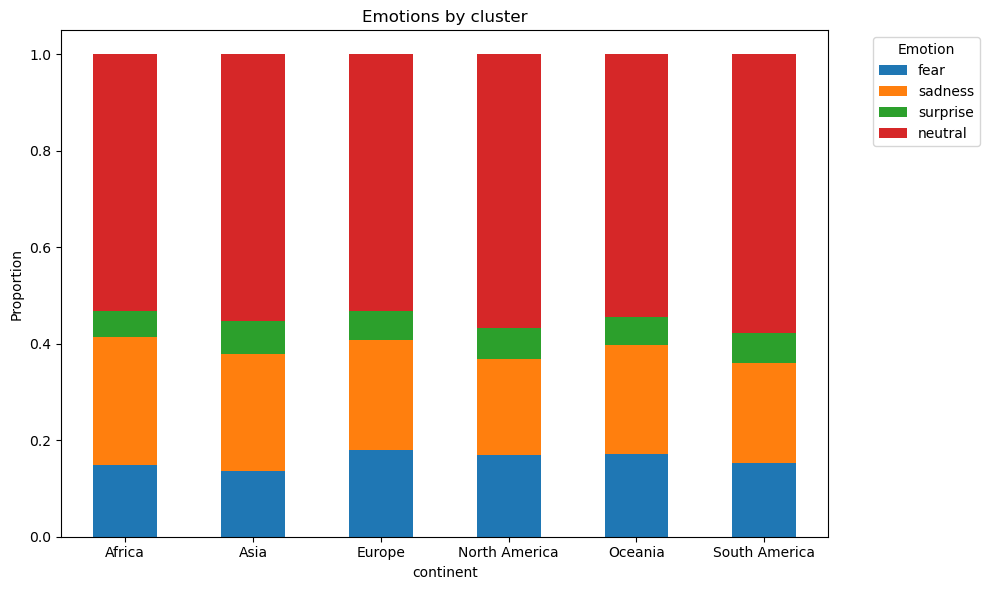

In [20]:
emotion_continent = data_km_with_continent.drop('cluster_km', axis=1).copy()
emotion_per_continent = emotion_continent.groupby('continent').mean()#.drop('neutral', axis=1)
emotion_per_continent = emotion_per_continent.apply(lambda x: x / x.sum(), axis=1)
emotion_per_continent.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Emotions by cluster')
plt.ylabel('Proportion')
plt.xlabel('continent')
plt.xticks(rotation = 0)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
data_km  = data_kmeans.drop(['PCA1_km', 'PCA2_km', 'PCA3_km'], axis=1).copy()
mean_emotions_per_cluster = data_km.drop(['category','Wikipedia_movie_ID'], axis=1).groupby('cluster_km').mean()
mean_emotions_per_cluster = mean_emotions_per_cluster.reset_index().melt(
    id_vars='cluster_km',
    var_name='Emotion',
    value_name='Proportion'
)

mean_emotions_per_cluster.rename(columns={'cluster_km': 'Cluster'}, inplace=True)

fig = px.bar(
    mean_emotions_per_cluster,
    x='Cluster',
    y='Proportion',
    color='Emotion',
    title='Stacked Barplot of Emotions by Cluster',
    text_auto=True
)

fig.update_layout(barmode='stack', xaxis={'categoryorder': 'total descending'})

fig.show()

In [19]:
category_cluster_counts = data_kmeans.groupby(['category', 'cluster_km']).size().reset_index(name='count')
categories = category_cluster_counts['category'].unique()

fig = make_subplots(
    rows=(len(categories) + 1) // 2,  
    cols=2,  
    specs=[[{'type': 'domain'}, {'type': 'domain'}] for _ in range((len(categories) + 1) // 2)],
    subplot_titles=categories  
)

row, col = 1, 1
for category in categories:
    category_data = category_cluster_counts[category_cluster_counts['category'] == category]
    fig.add_trace(
        go.Pie(
            labels=category_data['cluster_km'].astype(str), 
            values=category_data['count'],  
            name=category,  
            textinfo='percent+label'  
        ),
        row=row,
        col=col
    )
    col += 1
    if col > 2:  
        row += 1
        col = 1

fig.update_layout(
    title="Cluster repartition per category",
    height=300 * ((len(categories) + 1) // 2),  
    showlegend=True
)

fig.show()